In [1]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/My Drive/TFM/data/'
input_path = path + '{}'
output_path = path + 'output/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Librerías GDL

En este notebook, se va a ilustrar el uso de dos librerías bastante conocidas en el aprendizaje profundo geométrico: `Graphein` y `PyTorch Geometric`.

Para ello, se va a trabajar con un conjunto de datos sobre el cambio estructural de proteínas tras la unión del ligando, llamado *Protein Structural Change Data (PSCDB)*, que consiste en pares estructurales de proteínas de estados libres y unidos a ligando por medio de 7 clases de movimiento de reordenación estructural:
* Movimiento de dominio acoplado
* Movimiento de dominio independiente
* Movimiento local acoplado
* Movimiento local independiente
* Movimiento de ligando enterrado
* Sin movimiento significativo
* Otro tipo de movimiento

**Contexto**: las proteínas son moléculas flexibles que sufren cambios estructurales para funcionar. El banco de datos de proteínas contiene múltiples entradas para proteínas idénticas determinadas en diferentes condiciones, por ejemplo, con y sin una molécula de ligando, lo que proporciona información importante para comprender los cambios estructurales relacionados con las funciones de las proteínas.

**Objetivo**: clasificación de grafos para predecir qué clase de reorganización estructural experimenta una proteína al unirse a un ligando.

En primer lugar, se va a preprocesar el conjunto de datos ([pscdb.zip](https://dbarchive.biosciencedbc.jp/data/pscdb/LATEST/pscdb.zip)).



In [2]:
import requests, zipfile, io
import pandas as pd

# Descarga de datos
url = 'https://dbarchive.biosciencedbc.jp/data/pscdb/LATEST/pscdb.zip'
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall(path=path)
z.close()

# Preprocesamiento de datos
df = pd.read_csv(input_path.format('pscdb.csv')) # lectura de datos
df['Ligand binding'] = ' ' + df['Ligand binding']
df['Ligand binding'] = df['Ligand binding'].fillna('') # reemplazar valores nan
df['Type of motion'] += df['Ligand binding'] # obtener todos los tipos de movimiento
df['Type of motion'] = df['Type of motion'].str.split("/", expand=True)[0] # unificar los subtipos de movimiento "Other"

# Separación en canales
free_structures = df['FreeID'].str.split('_', expand=True)
bound_structures = df['BoundID'].str.split('_', expand=True)

# Añadir columnas
df['Free PDB'] = free_structures[0]
df['Free Chains'] = free_structures[1]
df['Bound PDB'] = bound_structures[0]
df['Bound Chains'] = bound_structures[1]

# Filtrar NAS
df = df[~df['Free PDB'].isna()]
df = df[~df['Bound PDB'].isna()]
df = df[~df['Type of motion'].isna()]

# Columnas interesantes
columns = ['Protein name', 'Ligands', 'Type of motion', 'Free PDB', 'Free Chains', 'Bound PDB', 'Bound Chains']
df = df[columns]

# Eliminar duplicados
df = df.drop_duplicates()

df.to_csv(input_path.format('preprocess_pscdb.csv'), index=False)
df.head()

Protein name Ligands  Type of motion  \
0                              CITRATE SYNTHASE   2xCIC  Domain Coupled   
1                              CITRATE SYNTHASE   2xCIC   Local Coupled   
3                        TRYPTOPHAN-TRNA LIGASE   2xATP  Domain Coupled   
4                        TRYPTOPHAN-TRNA LIGASE   2xATP   Local Coupled   
5  3-PHOSPHOSHIKIMATE 1-CARBOXYVINYLTRANSFERASE     RC1  Domain Coupled   

  Free PDB Free Chains Bound PDB Bound Chains  
0     5csc          AB      6cts           AA  
1     5csc          AB      6cts           AA  
3     1d2r          AD      1m83           AA  
4     1d2r          AD      1m83           AA  
5     2gg4           A      2pqc            A

Algunas de las columnas del conjunto de datos anterior son:
* Ligands: nombre del ligando (PDB)
* Type of motion: tipo de movimiento
* Free PDB: PDB ID de la forma libre de ligandos
* Free Chains: canales de la forma libre de ligandos
* Bound PDB: PDB ID de la forma unida al ligando
* Bound Chains: canales de la forma unida al ligando

En la siguiente sección se explicarán los conceptos básicos relacionados con las proteínas.

In [3]:
print(f'El conjunto de datos tiene {df.shape[0]} filas y {df.shape[1]} columnas')

El conjunto de datos tiene 938 filas y 7 columnas


Los datos no están balanceados, hay mucha diferencia en la cantidad de datos de algunas de sus clases, la clase minoritaria es "Otro tipo de movimiento" y la mayoritaria "Sin movimiento significativo".

In [4]:
df.groupby('Type of motion').count()['Protein name'].sort_values()

Type of motion
Other                  35
Domain Coupled         59
Domain Independent     72
Buried ligand         104
Local Coupled         151
Local Independent     206
No significant        311
Name: Protein name, dtype: int64

A continuación, se va a mostrar cómo la librería `Graphein` permite tratar con dichos datos de proteínas. Posteriormente, se utilizará la librería `PyTorch Geometric` para entrenar y evaluar una red neuronal de grafo con el conjunto de datos anterior.

---

## Graphein

Este paquete proporciona funcionalidad para construir representaciones de grafos y de malla superficial de proteínas, moléculas, ARN y redes de interacción biológica.

**Características**:
* Flexible: permite al usuario parametrizar la construcción del grafo.
* Escalable: admite estructuras complejas de proteínas.
* Contiene herramientas de preprocesamiento para preparar archivos de estructuras experimentales.
* Elabora análisis basados en redes y en la teoría de grafos de estructuras de proteínas con un alto rendimiento.

Además, permite la compatibilidad con los formatos estándar de bibliotecas de aprendizaje profundo geométrico, por ejemplo, `NetworkX.Graph`, `torch_geometric.data.Data` y `dgl.DGLGraph`.

El repositorio se encuentra en [a-r-j/graphein](https://github.com/a-r-j/graphein).

In [5]:
# Instalación de Graphein
!pip install graphein[extras]

# Instalación de pymol
!sudo apt-get install pymol

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
pymol is already the newest version (2.5.0+dfsg-1build1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


Ahora se expone la funcionalidad del paquete para el tratamiento de datos de las proteínas.

### Proteína

Es una macromolécula constituida por una o más cadenas de residuos de aminoácidos, que a su vez son moléculas formadas por átomos.

**Banco de datos**:

* *Protein Data Bank (PDB)* (Banco de Datos de Proteínas): es una base de datos que se encuentra bajo dominio público sobre la estructura tridimensional de las proteínas y ácidos nucleicos.
Cada modelo molecular (archivo de coordenadas atómicas) del banco de datos tiene un código de acceso o identificación único.

* *AlphaFold Protein Structure Database*: proporciona acceso abierto a más de 200 millones de predicciones de estructuras de proteínas para acelerar la investigación científica. Para acceder a estas estructuras se necesita su código UniProt correspondiente.

**Representación**: se pueden utilizar varios tipos de grafo:
* Grafo de residuos
* Grafo atómico

En esta sección, se va a trabajar con el grafo de residuos, el grafo atómico es prácticamente análogo.

Se va a trabajar con la proteína pirofosfatasa.

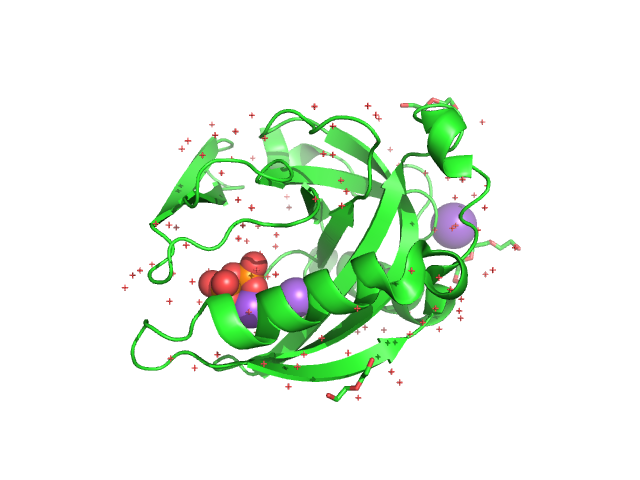

In [6]:
from graphein.utils.pymol import MolViewer
pymol = MolViewer()
pymol.delete("all") # eliminar todos los objetos de otras sesiones si es necesario
pymol.fetch("3eiy")
#pymol.show_as("cartoon")
pymol.display()

#### Configuración

`Graphein` está diseñado para procesar conjuntos de datos de estructuras de proteínas en grafos. Para ello, se utiliza una configuración global `ProteinGraphConfig` dónde:
* `granularity`: especifica la granularidad del grafo, es decir, qué representan los nodos.
Los valores posibles son:
  * Identificadores de átomo: p. ej., "CA" para α-carbono
  * "centroid": para utilizar centroides de residuo, se utiliza la media de las coordenadas x, y, z de los átomos del residuo.
  * "atom": para la construcción a nivel de átomo.
* `keep_hets`: booleano que especifica si mantener o no los heteroátomos (átomos no proteicos) presentes en el archivo .pdb.
* `insertions`: booleano que especifica si se conservan o no las inserciones (adición de uno o más nucleótidos en un segmento de ADN) en el archivo .pbd.
* `deprotonate`: booleano que indica si se eliminan o no los átomos de hidrógeno.

In [7]:
from graphein.protein.config import ProteinGraphConfig

params_to_change = {"granularity": "centroids"}
config = ProteinGraphConfig(**params_to_change)
config.dict()

{'granularity': 'centroids',
 'keep_hets': [],
 'insertions': True,
 'alt_locs': 'max_occupancy',
 'pdb_dir': None,
 'verbose': False,
 'exclude_waters': True,
 'deprotonate': False,
 'protein_df_processing_functions': None,
 'edge_construction_functions': [<function graphein.protein.edges.distance.add_peptide_bonds(G: 'nx.Graph') -> 'nx.Graph'>],
 'node_metadata_functions': [<function graphein.protein.features.nodes.amino_acid.meiler_embedding(n: str, d: Dict[str, Any], return_array: bool = False) -> Union[pandas.core.series.Series, numpy.ndarray]>],
 'edge_metadata_functions': None,
 'graph_metadata_functions': None,
 'get_contacts_config': None,
 'dssp_config': None}

#### Lectura y preprocesamiento de datos

`Graphein` puede trabajar con datos a partir de:

*   Archivo .pbd: permite realizar el preprocesamiento que se desee.
*   Código de acceso pbd: devuelve una estructura de la propia pbd.

In [8]:
from graphein.protein.graphs import construct_graph
from graphein.protein.visualisation import plotly_protein_structure_graph

# Código pbd
g = construct_graph(config=config, pdb_code="3eiy")

# Archivo .pbd
g = construct_graph(config=config, path=input_path.format("3eiy.pdb"))

# Representación del grafo
p = plotly_protein_structure_graph(
    g,
    colour_edges_by="kind",
    colour_nodes_by="degree", # nodos coloreados por su grado
    label_node_ids=False,
    plot_title="Grafo de residuos con enlaces peptídicos",
    node_size_multiplier=1)

Output()

Output()

In [9]:
p.show()

También se puede construir un preprocesado desde cero a partir de un archivo .pbd.

Además, se pueden definir funciones propias para el preprocesado.

In [10]:
from graphein.protein.graphs import read_pdb_to_dataframe, process_dataframe, deprotonate_structure, convert_structure_to_centroids, subset_structure_to_atom_type, filter_hetatms, remove_insertions

# Lectura del dataframe a partir de un código pbd
pdb_code = "3eiy"
raw_df = read_pdb_to_dataframe(pdb_code=pdb_code)

# Aplicación de funciones de preprocesamiento
processing_funcs = [deprotonate_structure, convert_structure_to_centroids, remove_insertions]
df = process_dataframe(raw_df, atom_df_processing_funcs=processing_funcs)
df.head()

record_name  atom_number atom_name alt_loc residue_name chain_id  \
0        ATOM            2        CA                  SER        A   
1        ATOM            8        CA                  PHE        A   
2        ATOM           19        CA                  SER        A   
3        ATOM           25        CA                  ASN        A   
4        ATOM           33        CA                  VAL        A   

   residue_number insertion   x_coord    y_coord   z_coord  occupancy  \
0               2            3.254333  54.615498 -0.136833        1.0   
1               3            3.206000  51.417271  2.656727        1.0   
2               4            4.649333  50.090836 -2.889667        1.0   
3               5            7.057500  52.758999 -4.146375        1.0   
4               6            9.549714  51.575432  0.109000        1.0   

    b_factor element_symbol charge  model_idx  node_id residue_id  
0  52.540001              C                 1  A:SER:2    A:SER:2  
1  48.730000              C                 1  A:PHE:3    A:PHE:3  
2  47.000000              C                 1  A:SER:4    A:SER:4  
3  41.419998              C                 1  A:ASN:5    A:ASN:5  
4  32.410000              C                 1  A:VAL:6    A:VAL:6

A continuación, se construye el grafo a partir de los datos anteriores como sigue.

In [11]:
from graphein.protein.graphs import initialise_graph_with_metadata, add_nodes_to_graph
from graphein.protein.edges.distance import add_peptide_bonds, add_hydrogen_bond_interactions
from graphein.protein.graphs import compute_edges
import pandas as pd

g = initialise_graph_with_metadata(protein_df=df, # dataframe preprocesado
                                   raw_pdb_df=raw_df, # dataframe no preprocesado, para trazabilidad
                                   pdb_code = pdb_code,
                                   granularity = "centroid" # tipo de grafo
                                  )

# Añadir nodos
g = add_nodes_to_graph(g)


# Añadir aristas
g = compute_edges(g, funcs=[add_peptide_bonds, add_hydrogen_bond_interactions])

# Representación
p = plotly_protein_structure_graph(
    g,
    colour_edges_by="kind",
    colour_nodes_by="seq_position",
    label_node_ids=False,
    plot_title="Grafo de residuos a partir de preprocesado propio de los datos",
    node_size_multiplier=1
    )

In [12]:
p.show()

A continuación, vamos a preprocesar un conjunto de datos proveniente de AlphaFold Protein Structure Database.

Se va a estudiar At1g58602 (UnitProt Q8W3K0), una proteína de resistencia a enfermedades.

In [13]:
from graphein.protein.utils import download_alphafold_structure

# Descarga del archivo PDB correspondiente al UniProt Q8W3K0
protein_path = download_alphafold_structure("Q8W3K0", out_dir=output_path, aligned_score=False)

# Construcción del grafo
g = construct_graph(config=config, path=protein_path)

# Representación
p = plotly_protein_structure_graph(
    g,
    colour_edges_by="kind",
    colour_nodes_by="residue_name",
    label_node_ids=False,
    plot_title="Grafo de residuos con datos procedentes de AlphafoldDB",
    node_size_multiplier=0.5
    )

Output()

In [14]:
p.show()

#### Construcción de aristas

Se pueden añadir aristas entre dos nodos del grafo dependiendo del tipo de enlace entre sus moléculas respectivas:

* Enlace peptídico: unión de dos aminoácidos mediante la pérdida de una molécula de agua entre el grupo amino de un aminoácido y el grupo carboxilo del otro.
* Enlace de hidrógeno: se forman entre átomos de oxígeno esqueletales y átomos de hidrógeno amida.
* Enlace disulfuro.
* Enlace iónico.
* Enlace aromático: interacción con aminoácidos aromáticos.
* Enlace catión-π: interacción molecular no covalente entre la cara de un sistema pi rico en electrones con un catión adyacente.

In [15]:
from graphein.protein.edges.distance import (add_peptide_bonds,
                                             add_hydrogen_bond_interactions,
                                             add_disulfide_interactions,
                                             add_ionic_interactions,
                                             add_aromatic_interactions,
                                             add_aromatic_sulphur_interactions,
                                             add_cation_pi_interactions
                                            )

new_edge_funcs = {"edge_construction_functions": [add_peptide_bonds,
                                                  add_aromatic_interactions,
                                                  add_hydrogen_bond_interactions,
                                                  add_disulfide_interactions,
                                                  add_ionic_interactions,
                                                  add_aromatic_sulphur_interactions,
                                                  add_cation_pi_interactions]
                 }

config = ProteinGraphConfig(**new_edge_funcs)
g_link = construct_graph(config=config, pdb_code="3eiy")
p = plotly_protein_structure_graph(
    g_link,
    colour_edges_by="kind",
    colour_nodes_by="seq_position",
    label_node_ids=False,
    plot_title="Grafo de residuos con diferentes tipos de enlaces",
    node_size_multiplier=1
    )

Output()

In [16]:
p.show()

También se pueden añadir aristas basadas en el cálculo de la distancia entre moléculas:

* Triangulación Delaunay: añade aristas de forma que se verifique la condición de Delaunay, es decir, que la circunferencia circunscrita de cada triángulo no debe contener ningún otro vértice de la triangulación en su interior.
* KNN: añade aristas basadas en los k vecinos más cercanos.
* Distancia de corte.

In [17]:
from graphein.protein.edges.distance import add_delaunay_triangulation

new_edge_funcs = {"edge_construction_functions": [add_delaunay_triangulation]}
config = ProteinGraphConfig(**new_edge_funcs)

g = construct_graph(config=config, pdb_code="3eiy")
p = plotly_protein_structure_graph(
    G=g,
    colour_edges_by="kind",
    colour_nodes_by="seq_position",
    label_node_ids=False,
    node_size_multiplier=1,
    plot_title="Grafo de residuos a partir de la triangulación Delaunay"
    )

Output()

In [18]:
p.show()

In [19]:
from functools import partial
from graphein.protein.edges.distance import add_distance_threshold

# Aristas entre nodos cuya distancia es más de 10 y con 5 posiciones de diferencia como mínimo
new_edge_funcs = {"edge_construction_functions": [partial(add_distance_threshold, long_interaction_threshold=5, threshold=10.)]}
config = ProteinGraphConfig(**new_edge_funcs)

g = construct_graph(config=config, pdb_code="3eiy")
p = plotly_protein_structure_graph(
    g,
    colour_edges_by="kind",
    colour_nodes_by="seq_position",
    label_node_ids=False,
    plot_title="Grafo de residuos a partir de la distancia de corte",
    node_size_multiplier=1
    )

Output()

In [20]:
p.show()

In [21]:
from functools import partial
from graphein.protein.edges.distance import add_k_nn_edges

# Aristas basadas en los 3 vecinos más cercanos
new_edge_funcs = {"edge_construction_functions": [partial(add_k_nn_edges, k=3, long_interaction_threshold=0)]}
config = ProteinGraphConfig(**new_edge_funcs)

g = construct_graph(config=config, pdb_code="3eiy")
p = plotly_protein_structure_graph(
    g,
    colour_edges_by="kind",
    colour_nodes_by="seq_position",
    label_node_ids=False,
    plot_title="Grafo de residuos basado en KNN con k=3",
    node_size_multiplier=1
    )

Output()

In [22]:
p.show()

También se pueden definir funciones propias para la construcción de aristas.

#### Características

`Graphein` está diseñado para facilitar el aprendizaje geométrico profundo de estructuras de proteínas, por lo que se tiene una gran variedad de funciones de anotación de características.

Existen tres niveles de anotación:
* Nivel de nodo
* Nivel de arista
* Nivel de grafo

In [23]:
from graphein.protein.features.sequence.sequence import molecular_weight

# Anotación a nivel de grafo
new_graph_annotation_funcs = {"graph_metadata_functions": [molecular_weight]}
config = ProteinGraphConfig(**new_graph_annotation_funcs)

g = construct_graph(config=config, pdb_code="3eiy")
print("Secuencia A:", g.graph["sequence_A"])
print("Peso molecular de la secuencia A:", g.graph["molecular_weight_A"]) # Peso de 1 mol o N (número de Avogadro) número de moléculas de la proteína

Output()

Secuencia A: SFSNVPAGKDLPQDFNVIIEIPAQSEPVKYEADKALGLLVVDRFIGTGMRYPVNYGFIPQTLSGDGDPVDVLVITPFPLLAGSVVRARALGMLKMTDESGVDAKLVAVPHDKVCPMTANLKSIDDVPAYLKDQIKHFFEQYKALEKGKWVKVEGWDGIDAAHKEITDGVANFKK
Peso molecular de la secuencia A: 19029.71029999999


In [24]:
from graphein.protein.features.nodes.amino_acid import expasy_protein_scale

# Anotación a nivel de nodo
config = ProteinGraphConfig(**{"node_metadata_functions": [expasy_protein_scale]})
g = construct_graph(config=config, pdb_code="3eiy")

for n, d in g.nodes(data=True):
    print(d['expasy']) # Representa el perfil producido por cualquier escala de aminoácidos en una proteína seleccionada
    break

Output()

pka_cooh_alpha               2.21
pka_nh3                      9.15
pka_rgroup                   7.00
isoelectric_points           5.68
molecularweight            105.00
                            ...  
antiparallelbeta_strand      0.87
parallelbeta_strand          0.70
a_a_composition              6.90
a_a_swiss_prot               6.56
relativemutability         120.00
Name: SER, Length: 61, dtype: float64


Al igual que en el apartado anterior, también se pueden definir funciones propias para obtener características y metadatos de los diferentes elementos del grafo.

#### Análisis

`Graphein` permite realizar diversos análisis sobre la estructura de los grafos y las propiedades fisicoquímicas.

Se va a analizar el grafo "Grafo de residuos con diferentes tipos de enlaces".

En primer lugar, se va a mostrar la composición de residuos del grafo.
Esta librería permite mostrarlo a través de un diagrama de barras o un gráfico circular.

In [25]:
from graphein.protein.analysis import plot_residue_composition

fig = plot_residue_composition(g_link, sort_by="count", plot_type="bar")
fig.show()

También se puede representar gráficamente la distribución de los grados de los nodos en el grafo de proteínas.

In [26]:
from graphein.protein.analysis import plot_degree_distribution

fig = plot_degree_distribution(g_link)
fig.show()

Además, se puede obtener la distribución de los tipos de aristas en el grado.

In [27]:
from graphein.protein.analysis import plot_edge_type_distribution

fig = plot_edge_type_distribution(g_link, plot_type="bar", title="3ey - Edge type distribution")
fig.show()



---



## PyTorch Geometric

`PyG` (PyTorch Geometric) es una librería construida sobre PyTorch para escribir y entrenar fácilmente Redes Neuronales de Grafos (GNNs) para una amplia gama de aplicaciones relacionadas con datos estructurados.

**Características**:
* Consta de varios métodos para el aprendizaje profundo en grafos y otras estructuras irregulares, también conocido como aprendizaje profundo geométrico.
* Consta de cargadores de mini lotes fáciles de usar para operar en muchos grafos pequeños y gigantes individuales.
* Soporte multi GPU.
* Soporte DataPipe.

El repositorio se encuentra en [pyg-team/pytorch_geometric](https://github.com/pyg-team/pytorch_geometric).

In [28]:
# Instalación de Torch
! pip install torch==2.4.0

# Instalación de Torch Geometric
!pip install pyg_lib torch-scatter torch-sparse torch-cluster torch-spline-conv torch_geometric pytorch_lightning -f https://data.pyg.org/whl/torch-2.4.0+cu121.html

Looking in links: https://data.pyg.org/whl/torch-2.4.0+cu121.html


A continuación, se muestra la creación, entrenamiento y evaluación de una red neuronal de grafo a partir del conjunto de datos presentado anteriormente mediante este paquete. Además, se utilizará `Graphein` para preprocesar la base de datos PSCDB en grafos.

---

### Preparación de datos

En primer lugar, como la variable respuesta es una variable categórica con 7 clases, se codifica mediante el método *One Hot Encoding*.

In [29]:
import torch

df = pd.read_csv(input_path.format('preprocess_pscdb.csv')) # lectura de datos
y_list = [torch.Tensor(i) for i in pd.get_dummies(df['Type of motion']).values.tolist()] # etiqueta One Hot

A continuación, `Graphein` descargará automáticamente los archivos .PDB correspondientes seleccionando las cadenas relevantes de la estructura del PDB indicada en el conjunto de datos.

In [30]:
from graphein.protein.config import ProteinGraphConfig
from graphein.protein.edges.distance import add_k_nn_edges
from graphein.protein.graphs import construct_graph
from functools import partial
from tqdm.notebook import tqdm

# Configuración
params_to_change = {"edge_construction_functions": [partial(add_k_nn_edges, k=3, long_interaction_threshold=0)]}
config = ProteinGraphConfig(**params_to_change)

# Construcción del grafo
graph_list = []
for i in tqdm(range(len(df))):
  graph_list.append(construct_graph(config=config, pdb_code=df['Free PDB'].iloc[i], chain_selection=list(df['Free Chains'].iloc[i])))

  0%|          | 0/938 [00:00<?, ?it/s]

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Ahora se transforman los grafos anteriores a objetos pyg (`PyTorch Geometric`).

In [31]:
from graphein.ml.conversion import GraphFormatConvertor

# Instanciación del conversor
format_convertor = GraphFormatConvertor('nx', 'pyg', verbose='gnn', columns=None)

# Lista de grafos del tipo pyg
pyg_list = [format_convertor(graph) for graph in tqdm(graph_list)]

# Conjunto de datos que va a utilizar la red (grafo, y)
data = list(zip(pyg_list, y_list))

  0%|          | 0/938 [00:00<?, ?it/s]

Por último, se divide el conjunto de datos en entrenamiento, validación y test y se construyen los lotes (batch).

In [32]:
from torch_geometric.data import DataLoader
import numpy as np

np.random.seed(1) # fijar la semilla
n_data = len(data)
idx_all = np.arange(n_data) # índices del conjunto de datos
np.random.shuffle(idx_all) # reordenación de índices

# División del conjunto de datos
train_idx, valid_idx, test_idx = np.split(idx_all, [int(.8*n_data), int(.9*n_data)])
train, valid, test = [data[i] for i in train_idx], [data[i] for i in valid_idx], [data[i] for i in test_idx]

# Construcción de bacthes
batch_size = 32
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, drop_last=True)
valid_loader = DataLoader(valid, batch_size=batch_size)
test_loader = DataLoader(test, batch_size=batch_size)

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning:

'data.DataLoader' is deprecated, use 'loader.DataLoader' instead



### Construcción del modelo

Se ha creado un modelo que permite los siguientes tipos de redes:
* Graph Neural Network (GNN): el que se va a utilizar
* Graph Attention Networks (GAT)
* GraphSAGE

Además, tiene los siguientes elementos:
* Entrada: coordenadas ($x$, $y$, $z$) de los residuos del grafo residual de una proteína.
* Salida: probabilidad de que en dicha proteína se hayan realizado los diferentes tipos de movimientos.
* Optimizador: Adam.
* Función de pérdida: *entropía cruzada*.
* Función de evaluación: *accuracy*, *precision*, *recall* y *f1-score*.

In [33]:
from torchmetrics import Accuracy

num_classes = 7 # número de categorías de la variable respuesta
accuracy = Accuracy(task='multiclass', num_classes=num_classes) # instanciación del accuracy

# Configuración del modelo
config= {
    'n_hid': 8,
    'n_out': 8,
    'num_att_dim': 64,
    'num_heads': 32,
    'dropout': 0.5,
    'lr': 0.001
}

# Variables para monitorear el entrenamiento (clav: época, valor: lista del atributo correspondiente durante los steps)
train_epoch_losses, train_epoch_accuracy_scores, train_epoch_precision_scores, train_epoch_recall_scores, train_epoch_f1_scores= {}, {}, {}, {}, {}
valid_epoch_losses, valid_epoch_accuracy_scores, valid_epoch_precision_scores, valid_epoch_recall_scores, valid_epoch_f1_scores= {}, {}, {}, {}, {}

def update(variable, key, value):
  """Función para actualizar los diccionarios anteriores"""
  if key not in variable:
    variable[key] = [value]
  else:
    variable[key].append(value)

def summarize_mean_epoch(variable):
  """ Por cada época obtiene la media del atributo correspondiente en los diferentes steps"""
  variable_mean_epoch = {k: np.mean(v) for k, v in variable.items()}
  return variable_mean_epoch.values()

In [34]:
from torch_geometric.nn import GCNConv, GATConv, SAGEConv, global_add_pool
from torch.nn.functional import relu, softmax, cross_entropy
from pytorch_lightning.callbacks import ModelCheckpoint
from sklearn.metrics import f1_score, precision_score, recall_score
from torch.nn import functional as F
import pytorch_lightning as pl
import torch.nn as nn
import os

# Modelo
class GraphNets(pl.LightningModule):
    def __init__(self):
        super().__init__()

        if model_name == 'GCN': # Graph Convolutional Network
            self.layer1 = GCNConv(in_channels=3, out_channels=config['n_hid'])
            self.layer2 = GCNConv(in_channels=config['n_hid'], out_channels=config['n_out'])

        elif model_name == 'GAT': # Graph Attention Networks
            self.layer1 = GATConv(3, config['num_att_dim'], heads=config['num_heads'], dropout=config['dropout'])
            self.layer2 = GATConv(config['num_att_dim'] * config['num_heads'], out_channels=config['n_out'], heads=1, concat=False,
                                  dropout=config['dropout'])

        elif model_name == 'GraphSAGE':
            self.layer1 = SAGEConv(3, config['n_hid'])
            self.layer2 = SAGEConv(config['n_hid'], config['n_out'])

        self.decoder = nn.Linear(config['n_out'], num_classes) # transformación afín

    def forward(self, x_data):
        x, edge_index = x_data.coords, x_data.edge_index
        x = F.dropout(x, p=config['dropout'], training=self.training)
        x = self.layer1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=config['dropout'], training=self.training)
        x = self.layer2(x, edge_index)
        x = global_add_pool(x, batch=x_data.batch)
        x = self.decoder(x)
        return softmax(x, dim=1)

    def training_step(self, batch, batch_idx):
        x = batch[0]
        y = batch[1]
        y_hat = self(x)
        loss = cross_entropy(y_hat, y)
        acc = accuracy(y_hat, y)

        y_hat_softmax = torch.log_softmax(y_hat, dim = 1)
        y_hat_tags = torch.argmax(y_hat_softmax, dim = 1)
        y = torch.argmax(y, dim = 1)
        precision = precision_score(y.detach().cpu().numpy(), y_hat_tags.detach().cpu().numpy(), labels=np.unique(y_hat_tags), average='weighted')
        recall = recall_score(y.detach().cpu().numpy(), y_hat_tags.detach().cpu().numpy(), labels=np.unique(y_hat_tags), average='weighted', zero_division=np.nan)
        f1 = f1_score(y.detach().cpu().numpy(), y_hat_tags.detach().cpu().numpy(), labels=np.unique(y_hat_tags), average='weighted')

        self.log_dict({'train_loss': loss, 'train_acc': acc, 'train_precision': precision, 'train_recall': recall, 'train_f1': f1}, prog_bar=True, logger=True, on_step=True, on_epoch=True, enable_graph=True)

        update(train_epoch_losses, self.current_epoch, loss.detach().cpu().numpy())
        update(train_epoch_accuracy_scores, self.current_epoch, acc.detach().cpu().numpy())
        update(train_epoch_precision_scores, self.current_epoch, precision)
        update(train_epoch_recall_scores, self.current_epoch, recall)
        update(train_epoch_f1_scores, self.current_epoch, f1)
        return loss

    def validation_step(self, batch, batch_idx):
        x = batch[0]
        y = batch[1]
        y_hat = self(x)
        loss = cross_entropy(y_hat, y)
        acc = accuracy(y_hat, y)

        y_hat_softmax = torch.log_softmax(y_hat, dim = 1)
        y_hat_tags = torch.argmax(y_hat_softmax, dim = 1)
        y = torch.argmax(y, dim = 1)
        precision = precision_score(y.detach().cpu().numpy(), y_hat_tags.detach().cpu().numpy(), labels=np.unique(y_hat_tags), average='weighted')
        recall = recall_score(y.detach().cpu().numpy(), y_hat_tags.detach().cpu().numpy(), labels=np.unique(y_hat_tags), average='weighted', zero_division=np.nan)
        f1 = f1_score(y.detach().cpu().numpy(), y_hat_tags.detach().cpu().numpy(), labels=np.unique(y_hat_tags), average='weighted')

        self.log_dict({'val_loss': loss, 'val_acc': acc, 'val_precision': precision, 'val_recall': recall, 'val_f1': f1}, prog_bar=True, logger=True, on_epoch=True)

        update(valid_epoch_losses, self.current_epoch, loss.detach().cpu().numpy())
        update(valid_epoch_accuracy_scores, self.current_epoch, acc.detach().cpu().numpy())
        update(valid_epoch_precision_scores, self.current_epoch, precision)
        update(valid_epoch_recall_scores, self.current_epoch, recall)
        update(valid_epoch_f1_scores, self.current_epoch, f1)

    def test_step(self, batch, batch_idx):
        x = batch[0]
        y = batch[1]
        y_hat = self(x)
        loss = cross_entropy(y_hat, y)
        acc = accuracy(y_hat, y)

        y_hat_softmax = torch.log_softmax(y_hat, dim = 1)
        y_hat_tags = torch.argmax(y_hat_softmax, dim = 1)
        y = torch.argmax(y, dim = 1)
        precision = precision_score(y.detach().cpu().numpy(), y_hat_tags.detach().cpu().numpy(), labels=np.unique(y_hat_tags), average='weighted')
        recall = recall_score(y.detach().cpu().numpy(), y_hat_tags.detach().cpu().numpy(), labels=np.unique(y_hat_tags), average='weighted', zero_division=np.nan)
        f1 = f1_score(y.detach().cpu().numpy(), y_hat_tags.detach().cpu().numpy(), labels=np.unique(y_hat_tags), average='weighted')

        self.log_dict({'test_loss': loss, 'test_acc': acc, 'test_precision': precision, 'test_recall': recall, 'test_f1': f1}, prog_bar=True, logger=True, on_epoch=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=config['lr'])
        return optimizer

# Checkpoint
file_path = output_path + 'graphein_model'
if not os.path.exists(file_path):
    os.mkdir(file_path)

checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath=file_path,
    filename="model-{epoch:02d}-{val_loss:.2f}",
    save_top_k=1,
    mode="min",
)

### Entrenamiento del modelo

In [35]:
# Instanciación del modelo
model_name = 'GCN' # tipo de modelo
model = GraphNets()

# Entrenamiento
trainer = pl.Trainer(max_epochs=200, callbacks=[checkpoint_callback], log_every_n_steps=1)
trainer.fit(model, train_loader, valid_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/drive/My Drive/TFM/data/output/graphein_model exists and is not empty.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | layer1  | GCNConv | 32     | train
1 | layer2  | GCNConv | 72     | train
2 | decoder | Linear  | 63     | train
--------------------------------------------
167       Trainable params
0         Non-trainable params
167       Total params
0.001     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


A continuación, se representa la evolución del modelo durante el entrenamiento.

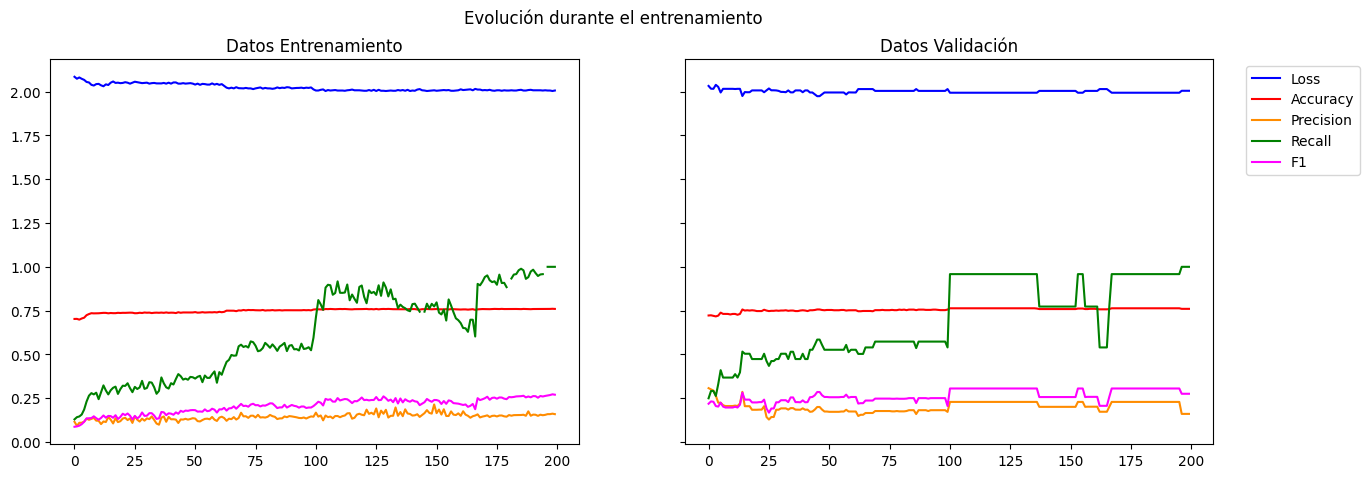

In [43]:
from matplotlib import pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(15, 5))

ax1.plot(summarize_mean_epoch(train_epoch_losses), label="Loss", color="blue")
ax1.plot(summarize_mean_epoch(train_epoch_accuracy_scores), label="Accuracy", color="red")
ax1.plot(summarize_mean_epoch(train_epoch_precision_scores), label="Precision", color="darkorange")
ax1.plot(summarize_mean_epoch(train_epoch_recall_scores), label="Recall", color="green")
ax1.plot(summarize_mean_epoch(train_epoch_f1_scores), label='F1', color="magenta")
ax1.set_title("Datos Entrenamiento")

ax2.plot(summarize_mean_epoch(valid_epoch_losses), label="Loss", color="blue")
ax2.plot(summarize_mean_epoch(valid_epoch_accuracy_scores), label="Accuracy", color="red")
ax2.plot(summarize_mean_epoch(valid_epoch_precision_scores), label="Precision", color="darkorange")
ax2.plot(summarize_mean_epoch(valid_epoch_recall_scores), label="Recall", color="green")
ax2.plot(summarize_mean_epoch(valid_epoch_f1_scores), label='F1', color="magenta")
ax2.legend(bbox_to_anchor=(1.05, 1.0), loc="upper left")
ax2.set_title('Datos Validación')

fig.suptitle('Evolución durante el entrenamiento')

plt.show()

### Evaluación del modelo

In [37]:
# Evaluación del modelo en el conjunto test
best_model = GraphNets.load_from_checkpoint(checkpoint_callback.best_model_path) # mejor modelo obtenido en el entrenamiento
out_best_test = trainer.test(best_model, test_loader)[0]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7505952715873718     │
│          test_f1          │    0.19318711757659912    │
│         test_loss         │     2.017505407333374     │
│      test_precision       │    0.23130302131175995    │
│        test_recall        │    0.3541666567325592     │
└───────────────────────────┴───────────────────────────┘